In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from scipy.stats import shapiro, normaltest, kurtosis, skew
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.api import qqplot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone
from sklearn.feature_selection import SelectKBest, f_regression, RFECV
import joblib
import os

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

ModuleNotFoundError: No module named 'statsmodels'

# **Solar Power Generation Prediction:**

**Nowadays, the amount of energy consumed has sharply increased. As a result, the human race has been increasingly investing in renewable energy due to concerns about the environment and global warming. Therefore, in parallel with the rise in consumption, it is also evident in some countries that photovoltaic energy and wind energy are gaining significance in the energy matrix. With this in mind, this project aims to analyze and predict the generation of solar power plants using a dataset downloaded from Kaggle.**

# **Dictionary (Columns):**
* WindSpeed
* Sunshine
* AirPressure
* Radiation
* AirTemperature
* RelativeAirHumidity
* SystemProduction (Target)

# **1. Importing data:**

In [2]:
df = pd.read_csv("/kaggle/input/solar-powe-generation-data/Solar Power Plant Data.csv")

In [3]:
df.head()

,Date-Hour(NMT),WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction
0,01.01.2017-00:00,0.6,0,1003.8,-7.4,0.1,97,0.0
1,01.01.2017-01:00,1.7,0,1003.5,-7.4,-0.2,98,0.0
2,01.01.2017-02:00,0.6,0,1003.4,-6.7,-1.2,99,0.0
3,01.01.2017-03:00,2.4,0,1003.3,-7.2,-1.3,99,0.0
4,01.01.2017-04:00,4.0,0,1003.1,-6.3,3.6,67,0.0


# **2. Data Cleaning**

In [4]:
# Information about the dataset:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date-Hour(NMT)       8760 non-null   object 
 1   WindSpeed            8760 non-null   float64
 2   Sunshine             8760 non-null   int64  
 3   AirPressure          8760 non-null   float64
 4   Radiation            8760 non-null   float64
 5   AirTemperature       8760 non-null   float64
 6   RelativeAirHumidity  8760 non-null   int64  
 7   SystemProduction     8760 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 547.6+ KB


In [5]:
# Missing data:
df.isna().sum()

Date-Hour(NMT)         0
WindSpeed              0
Sunshine               0
AirPressure            0
Radiation              0
AirTemperature         0
RelativeAirHumidity    0
SystemProduction       0
dtype: int64

In [6]:
# Changing Date-Hour(NMT) column type:
df['Date-Hour(NMT)'] = pd.to_datetime(df['Date-Hour(NMT)'], format="%d.%m.%Y-%H:%M")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date-Hour(NMT)       8760 non-null   datetime64[ns]
 1   WindSpeed            8760 non-null   float64       
 2   Sunshine             8760 non-null   int64         
 3   AirPressure          8760 non-null   float64       
 4   Radiation            8760 non-null   float64       
 5   AirTemperature       8760 non-null   float64       
 6   RelativeAirHumidity  8760 non-null   int64         
 7   SystemProduction     8760 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 547.6 KB


In [7]:
# Setting the Date-Hour(NUMT) as the index:
df.set_index("Date-Hour(NMT)", inplace=True)

In [8]:
# Let's change the type of the numeric variables:
df['Sunshine'] = df['Sunshine'].astype("int16")
df['RelativeAirHumidity'] = df['RelativeAirHumidity'].astype("int16")
df['WindSpeed'] = df['WindSpeed'].astype("float32")
df['Radiation'] = df['Radiation'].astype("float32")
df['AirTemperature'] = df['AirTemperature'].astype("float32")

In [9]:
# Information about the dataset:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2017-01-01 00:00:00 to 2017-12-31 23:00:00
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   WindSpeed            8760 non-null   float32
 1   Sunshine             8760 non-null   int16  
 2   AirPressure          8760 non-null   float64
 3   Radiation            8760 non-null   float32
 4   AirTemperature       8760 non-null   float32
 5   RelativeAirHumidity  8760 non-null   int16  
 6   SystemProduction     8760 non-null   float64
dtypes: float32(3), float64(2), int16(2)
memory usage: 342.2 KB


**Conclusions**
* No missing data.
* Date-Hour(NMT) is now a datetime type.
* Memory usage of the dataset reduced from 547.6 to 342.2 KB.

# 3. **Exploratory Data Analysis**

**3.1) Exploring the characteristics**

In [10]:
# Descriptive Statistics:
df.describe()

,WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,2.639823,11.180479,1010.361781,97.538498,6.978892,76.719406,684.746071
std,1.628754,21.171295,12.793971,182.336029,7.604266,19.278996,1487.454665
min,0.000000,0.000000,965.900000,-9.300000,-12.400000,13.000000,0.000000
25%,1.400000,0.000000,1002.800000,-6.200000,0.500000,64.000000,0.000000
50%,2.300000,0.000000,1011.000000,-1.400000,6.400000,82.000000,0.000000
75%,3.600000,7.000000,1018.200000,115.599998,13.400000,93.000000,464.249950
max,10.900000,60.000000,1047.300000,899.700012,27.100000,100.000000,7701.000000


In [11]:
# Range of datetime column:
print(f"Range of Datetime column: ({df.index.min()}) to ({df.index.max()})")

Range of Datetime column: (2017-01-01 00:00:00) to (2017-12-31 23:00:00)


In [12]:
# Let's see how many data points have negative Radiation:
df[df["Radiation"] < 0].shape

(4464, 7)

In [13]:
# Analysing average monthly Radiation and Sunshine:
df["Months"] = df.index.month_name()
df["Month_number"] = df.index.month
monthly_rad_sun = df.groupby(["Month_number", "Months"]).agg({"Radiation":"mean", "Sunshine":"mean"}).droplevel(level="Month_number")

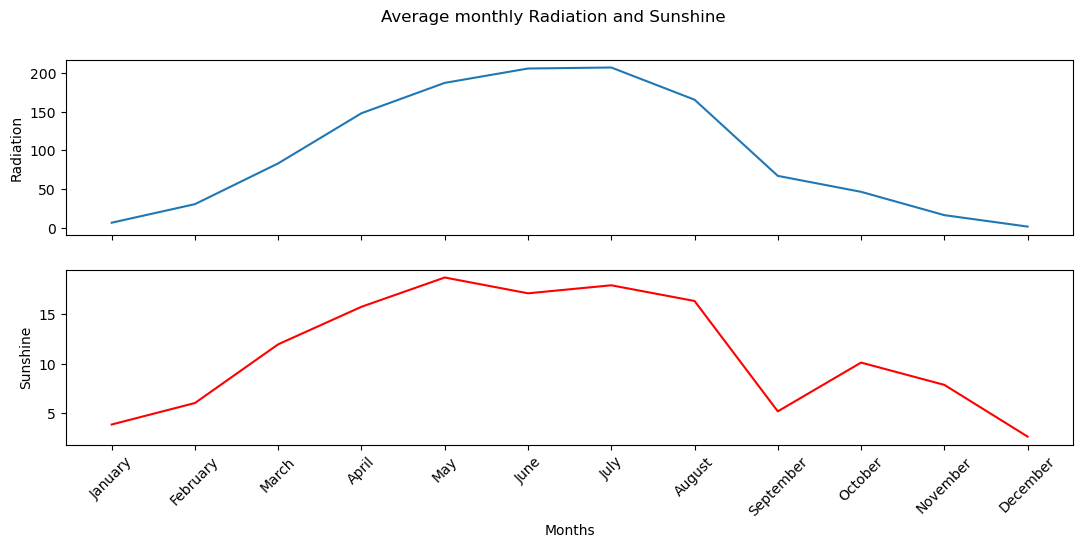

In [14]:
# Line plot of the Average monthly Radiation and Sushine
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(13, 5))
fig.suptitle("Average monthly Radiation and Sunshine")
plt.xticks(rotation=45)
sns.lineplot(monthly_rad_sun["Radiation"], ax=ax[0])
sns.lineplot(monthly_rad_sun["Sunshine"], ax=ax[1], c="r");

In [15]:
# Dropping Months and Month_number columns:
df.drop(columns=["Months", "Month_number"], inplace=True)

**Conclusions**
* One year of one-hour mesurements.
* As we can see from the statistic summary, there are some negative data points in Radiation column.
* Average Monthly Radiation is positive over the year.
* The increase of the Radiation and Sunshine between April and August may suggest that this location is
* situated in the Northern Hemisphere.
* Most data in SystemProduction and Sunshine columns may be zero.

**3.2) Distribution**

***We will look at the histogram of all variables***

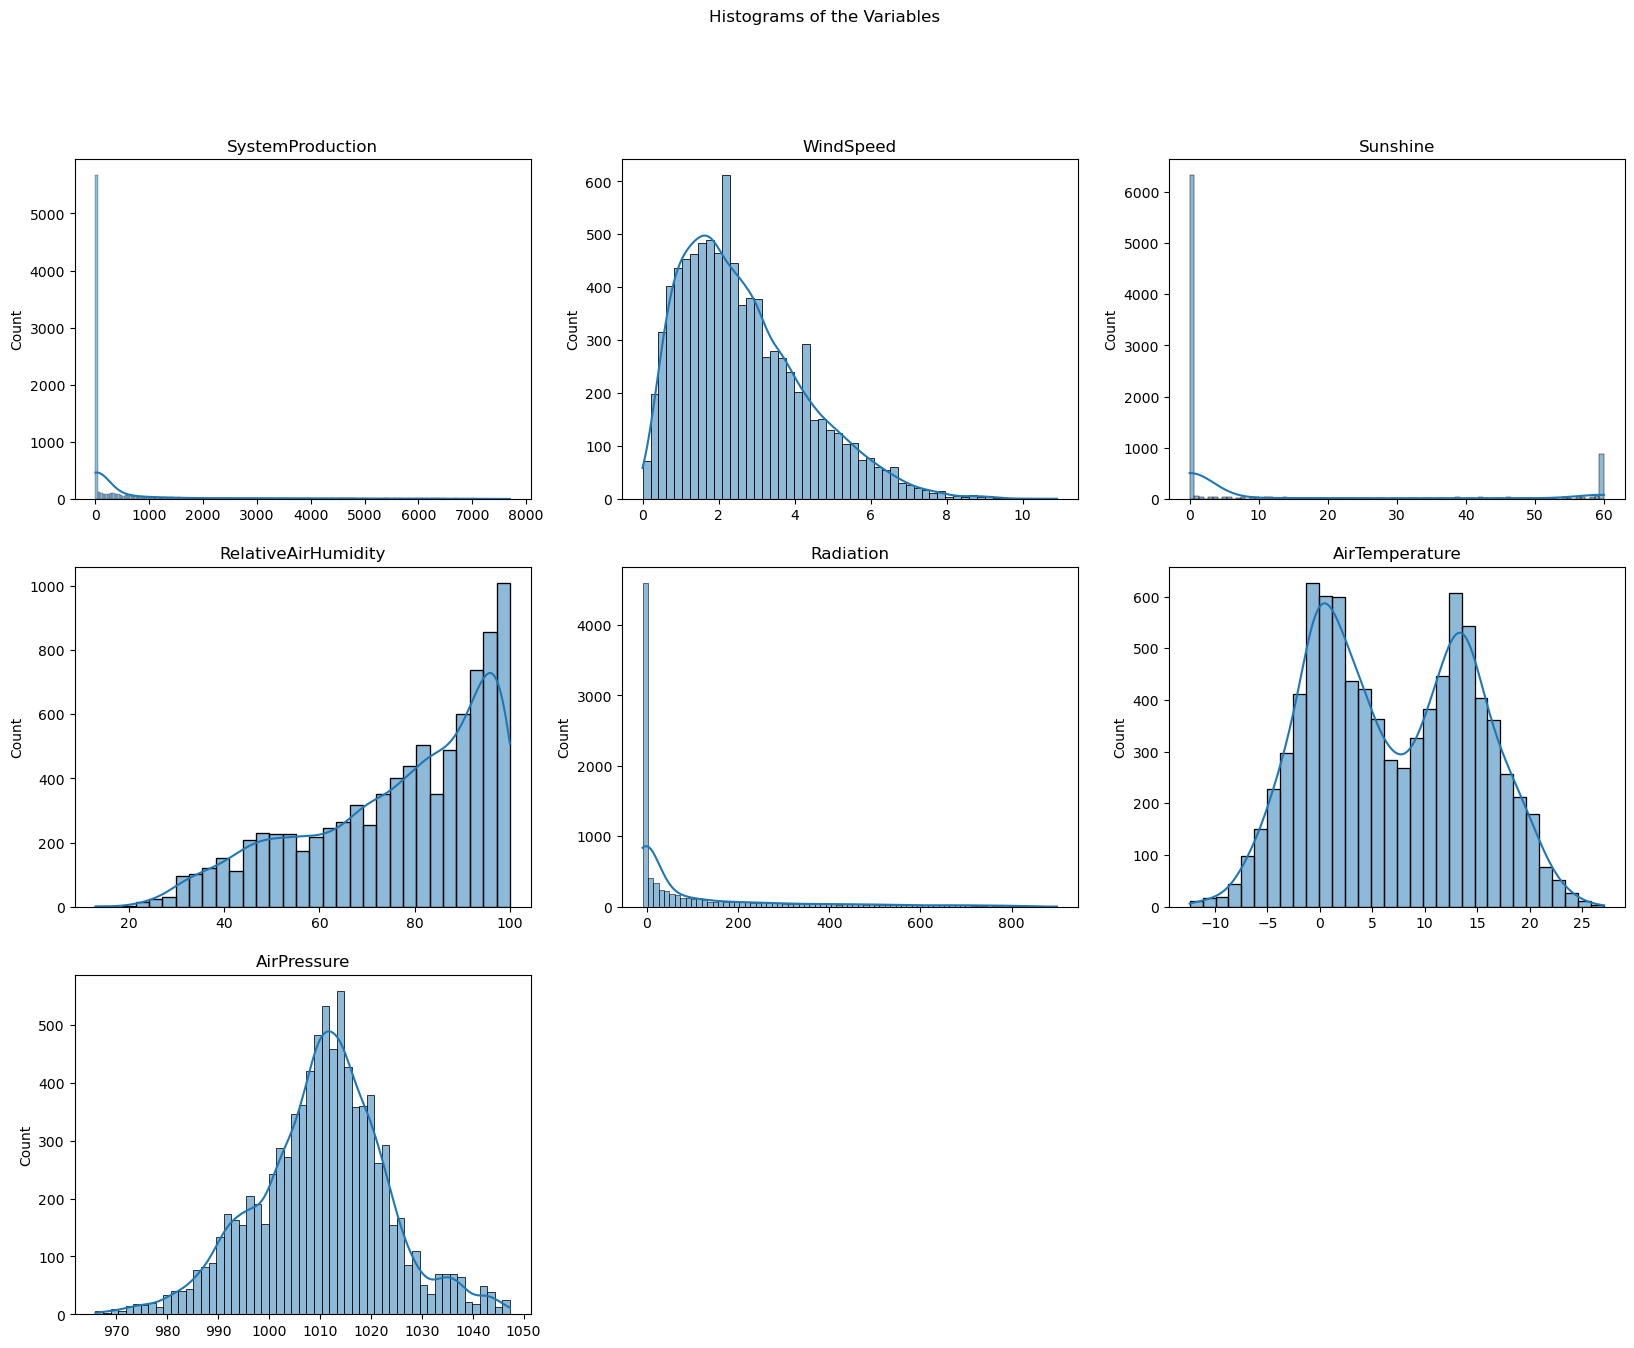

In [16]:
# Histograms:
fig, axes = plt.subplots(nrows=3, ncols=3, sharey=False, figsize=(20, 15))
fig.suptitle("Histograms of the Variables")
sns.histplot(df["SystemProduction"].values, ax=axes[0, 0], kde=True)
axes[0, 0].set_title("SystemProduction")
sns.histplot(df["WindSpeed"].values, ax=axes[0, 1], kde=True)
axes[0, 1].set_title("WindSpeed")
sns.histplot(df["Sunshine"].values, ax=axes[0][2], kde=True)
axes[0][2].set_title("Sunshine")
sns.histplot(df["RelativeAirHumidity"].values, ax=axes[1, 0], kde=True)
axes[1, 0].set_title("RelativeAirHumidity")
sns.histplot(df["Radiation"].values, ax=axes[1, 1], kde=True, legend=False)
axes[1, 1].set_title("Radiation")
sns.histplot(df["AirTemperature"].values, ax=axes[1, 2], kde=True)
axes[1, 2].set_title("AirTemperature")
sns.histplot(df["AirPressure"].values, ax=axes[2, 0], kde=True)
axes[2, 0].set_title("AirPressure");
axes[2, 1].set_visible(False)
axes[2, 2].set_visible(False)

**Looking at the Histograms, we may think that AirPressure column was drew from a normal distribution. Let's
look at the boxplots.**

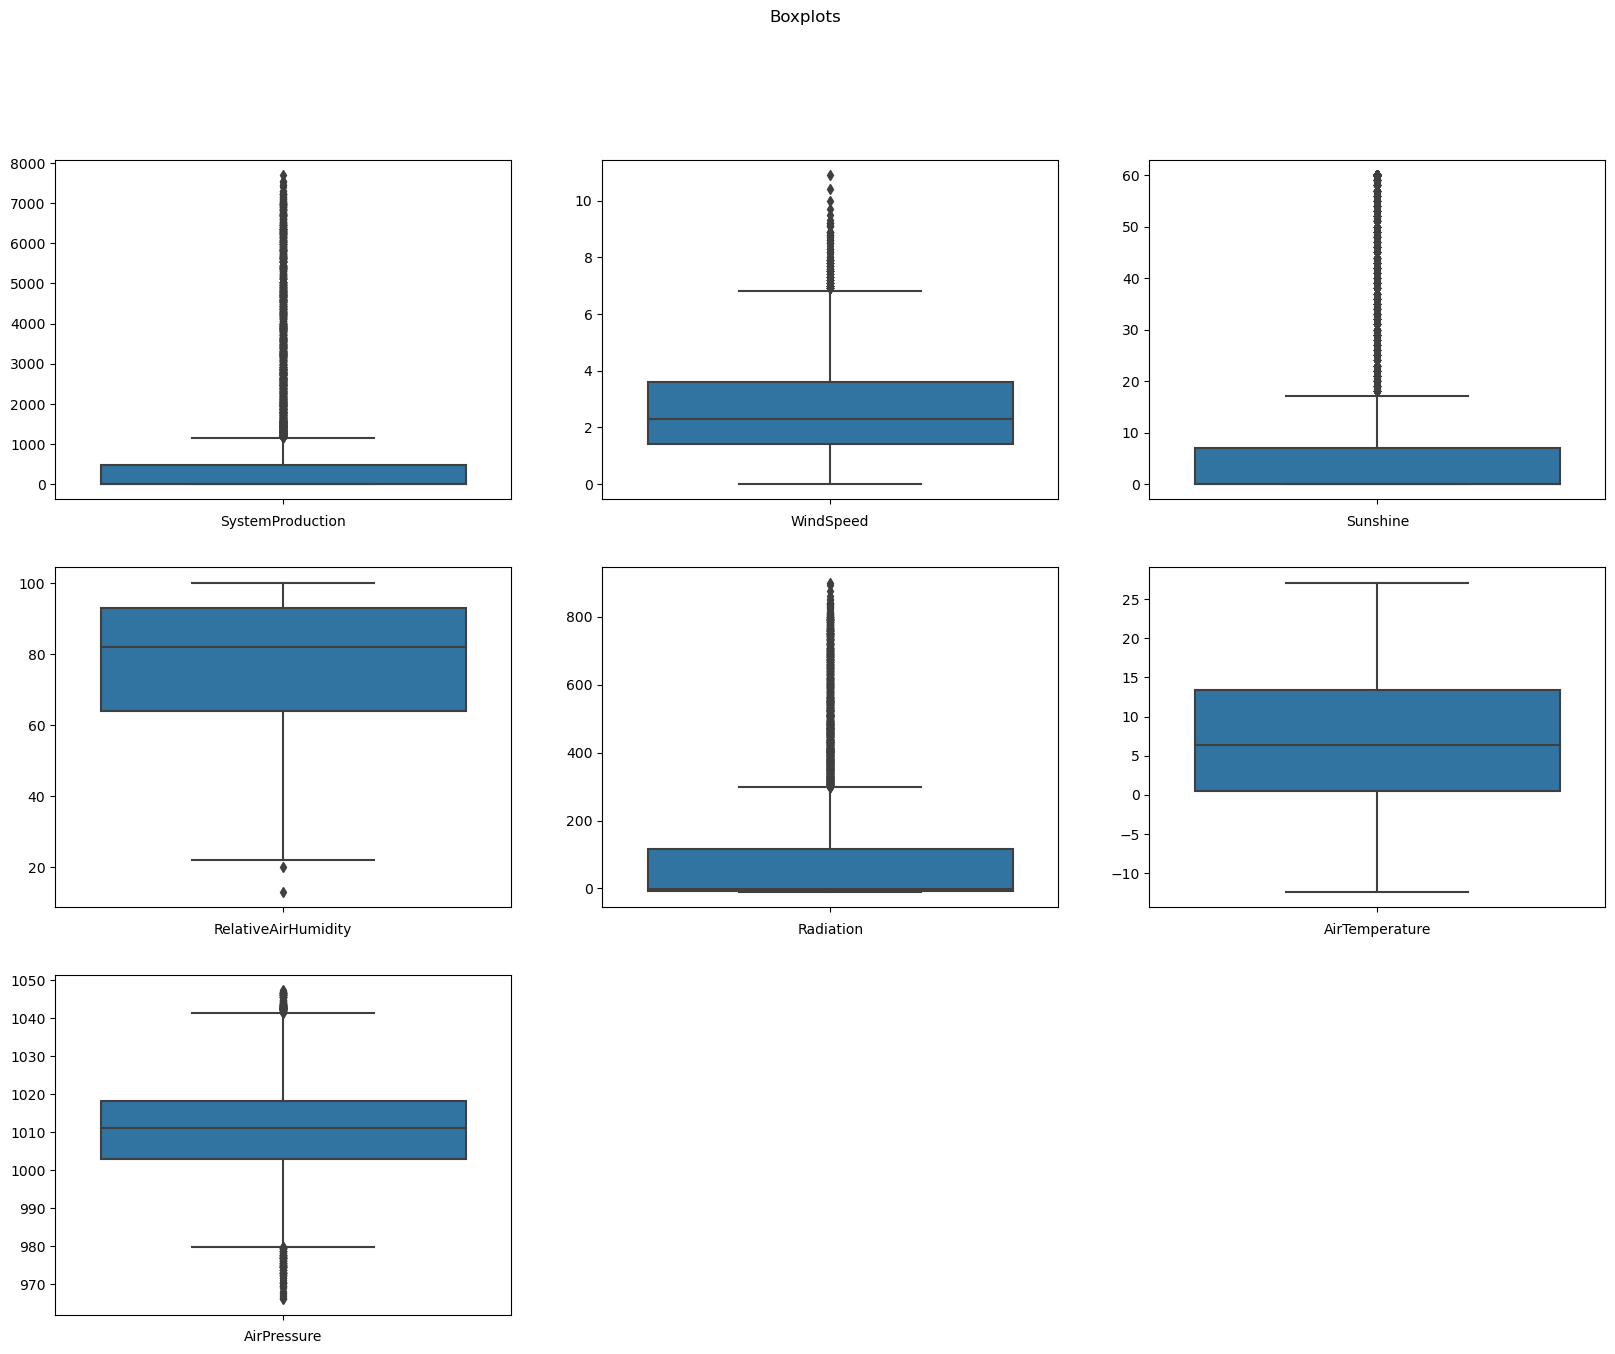

In [17]:
# BoxPlots:
fig, ax = plt.subplots(3, 3, figsize=(20, 15), sharey=False)
fig.suptitle("Boxplots")
sns.boxplot(y=df["SystemProduction"].values, ax=ax[0, 0])
ax[0, 0].set_xlabel("SystemProduction")
sns.boxplot(y=df["WindSpeed"].values, ax=ax[0, 1])
ax[0, 1].set_xlabel("WindSpeed")
sns.boxplot(y=df["Sunshine"].values, ax=ax[0, 2])
ax[0, 2].set_xlabel("Sunshine")
sns.boxplot(y=df["RelativeAirHumidity"].values, ax=ax[1, 0])
ax[1, 0].set_xlabel("RelativeAirHumidity")
sns.boxplot(y=df["Radiation"].values, ax=ax[1, 1])
ax[1, 1].set_xlabel("Radiation")
sns.boxplot(y=df["AirTemperature"].values, ax=ax[1, 2])
ax[1, 2].set_xlabel("AirTemperature")
sns.boxplot(y=df["AirPressure"].values, ax=ax[2, 0])
ax[2, 0].set_xlabel("AirPressure");
ax[2, 1].set_visible(False)
ax[2, 2].set_visible(False)

**3.3) Normality tests**

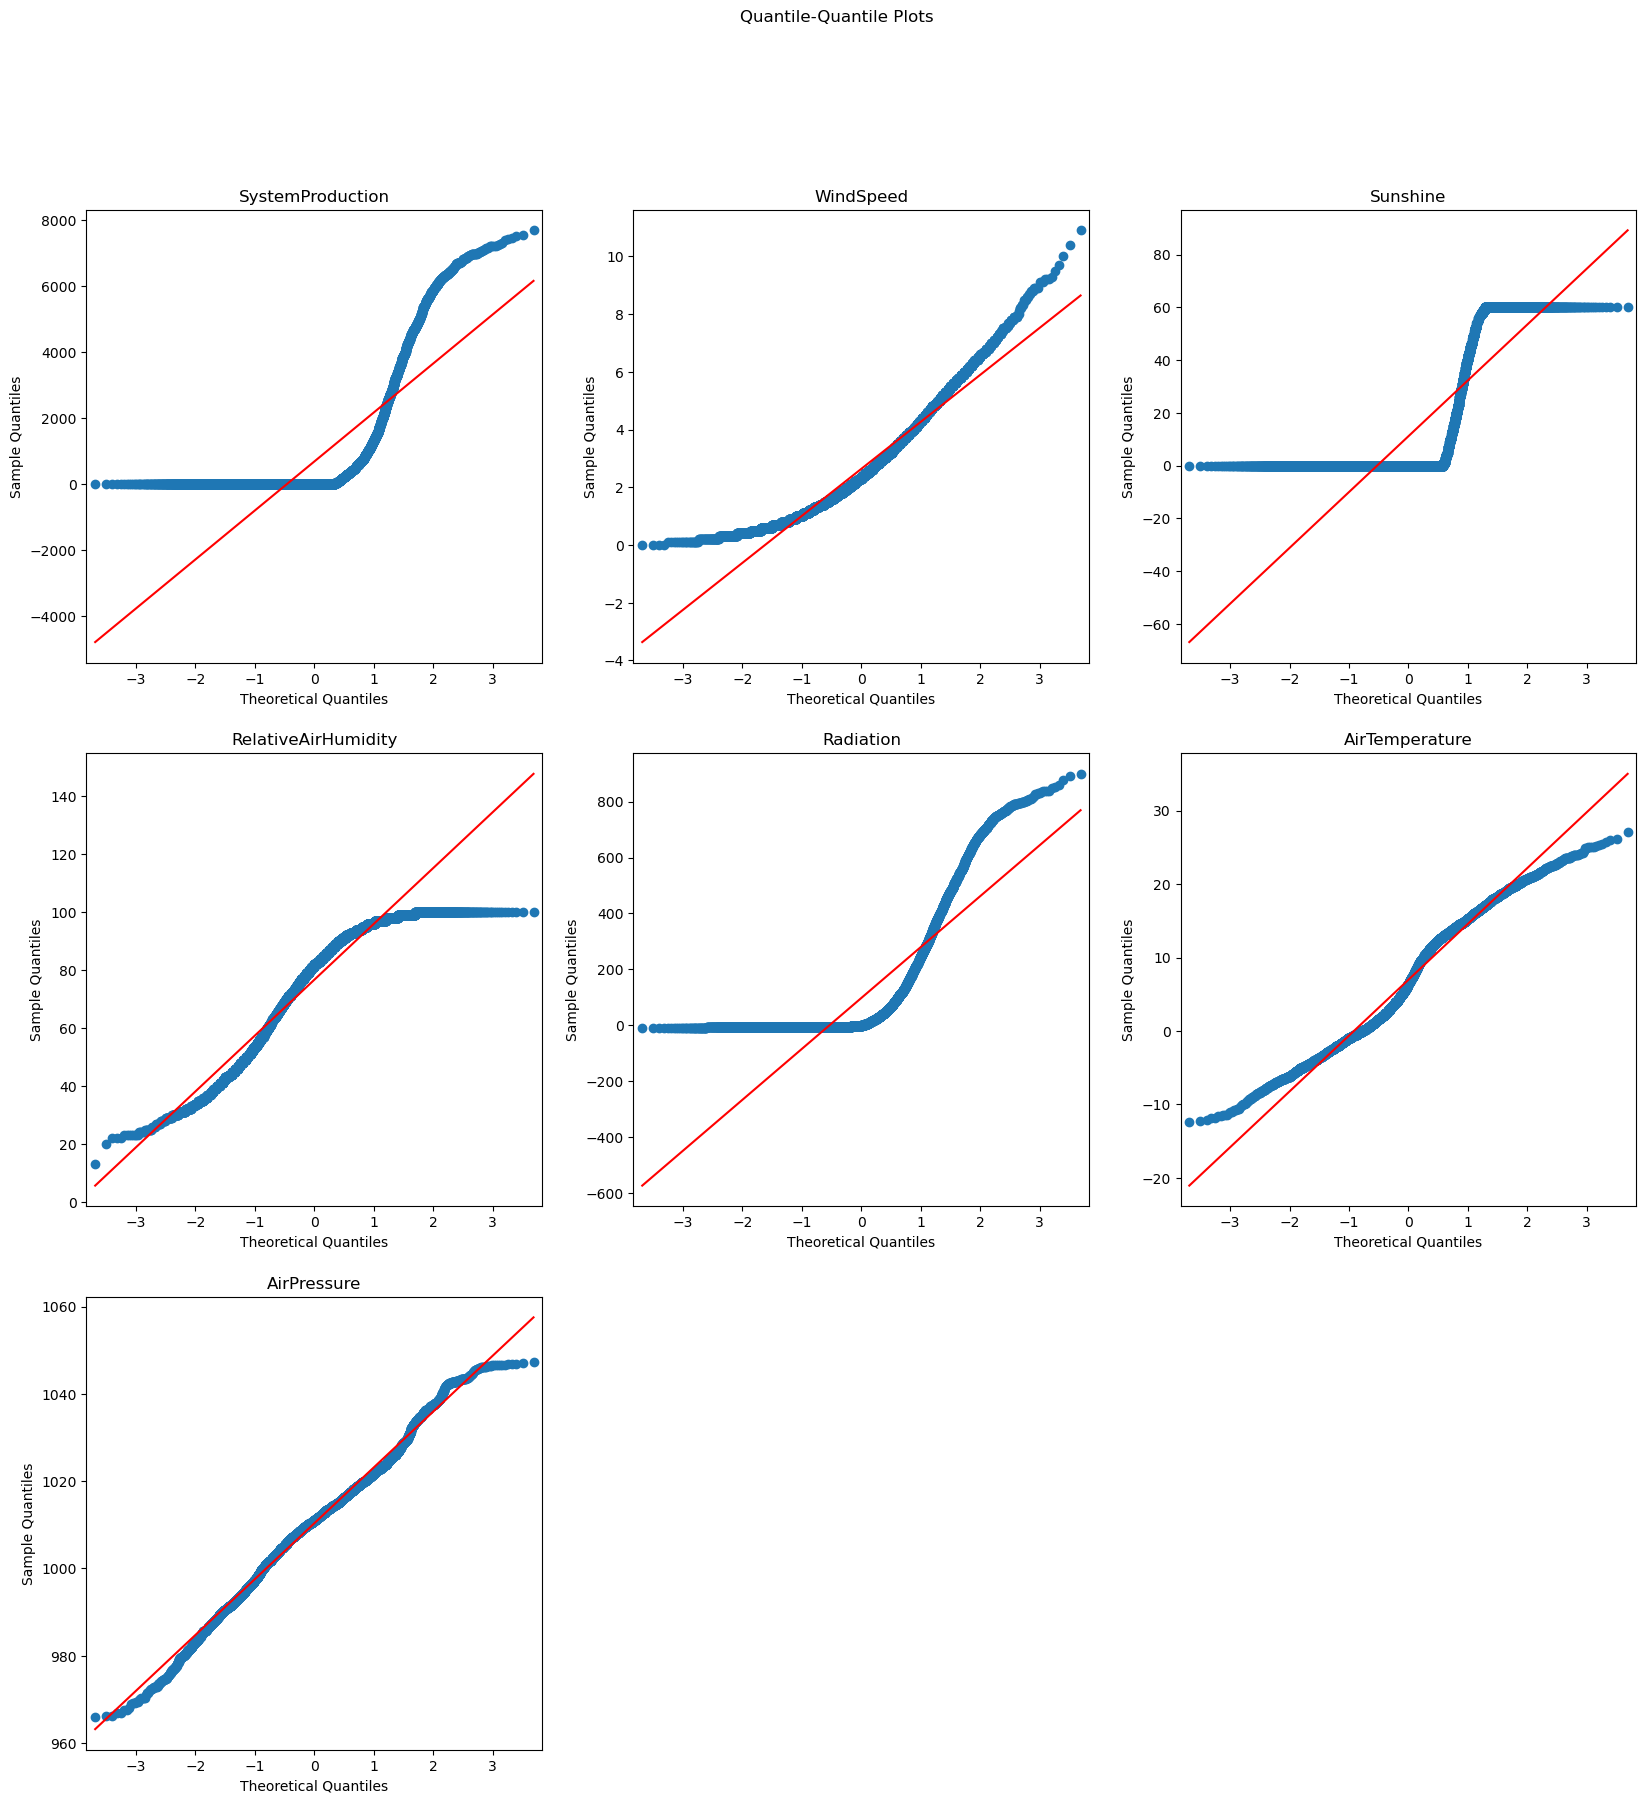

In [18]:
# QQ Plots:
# Defining subplots:
fig, axe = plt.subplots(3, 3, sharey=False, figsize=(20, 20))
fig.suptitle("Quantile-Quantile Plots")
# Plotting SystemProduction data:
qqplot(df["SystemProduction"], ax=axe[0, 0], line="s");
axe[0, 0].set_title("SystemProduction")
# Plotting WindSpeed data:
qqplot(df["WindSpeed"], ax=axe[0, 1], line="s")
axe[0, 1].set_title("WindSpeed")
# Plotting Sunshine data:
qqplot(df["Sunshine"], ax=axe[0, 2], line="s")
axe[0, 2].set_title("Sunshine")
# Ploting RelativeAirHumidity:
qqplot(df["RelativeAirHumidity"], ax=axe[1, 0], line="s")
axe[1, 0].set_title("RelativeAirHumidity")
# Radiation:
qqplot(df["Radiation"], ax=axe[1, 1], line="s")
axe[1, 1].set_title("Radiation")
# AirTemperature:
qqplot(df["AirTemperature"], ax=axe[1, 2], line="s")
axe[1, 2].set_title("AirTemperature")
# AirPressure
qqplot(df["AirPressure"], ax=axe[2, 0], line="s")
axe[2, 0].set_title("AirPressure");
axe[2, 1].set_visible(False)
axe[2, 2].set_visible(False)

**As we can see from the qqplot and the Histogram above, it seems tha AirPressure follows a normal
distribution. Let's quantify this assumption using statistical tests for normality.**
* H0: Data was drew from a normal distribution.
* H1: Data was not drew from a normal distribution.

**OBS: Using level of significance of 5% (alpha).**

**OBS2: Shapiro wilk p value is an approximate value due to the size of the sample being more than 5000.**

In [19]:
# Function that Calculates Shapiro-Wilk, Lilliefors and D'Agostino_K2 tests:
def normality_tests(df: any):
    tests_names = ["Shapiro-Wilk", "Lilliefors", "D'Agostino_K2"]
    extern_index = np.array(sorted(tests_names*2))
    intern_index = np.array(["statistic", "p-value"]*len(tests_names))
    
    mult_index = [
        extern_index,
        intern_index
    ]
    
    results = pd.DataFrame(index=mult_index, columns=df.columns)
    
    for c in df.columns:
        # First D'Agostino's K-squared test:
        k2, k2_p = normaltest(df[c])
        # Secondly we will use the Lilliefors test:
        lilliefors_result = lilliefors(df[c])
        ksstat, lilliefours_p = lilliefors_result
        # We will check the shapiro-Wilk test:
        shapiro_result = shapiro(df[c])
        shapiro_statistic, shapiro_p = shapiro_result.statistic, shapiro_result.pvalue
        results[c] = [k2, k2_p, ksstat, lilliefours_p, shapiro_statistic, shapiro_p]
    return results

In [20]:
# Function that calculates kurtosis and skewness of a dataset:
def kurtosis_skewness(dataset: any):
    index = ["Kurtosis", "Skewness"]
    results = pd.DataFrame(index=index, columns=dataset.columns)
    
    for c in dataset.columns:
        kurt = kurtosis(dataset[c])
        skewness = skew(dataset[c])
        results[c] = [kurt, skewness]
        
    return results

In [21]:
# Normality test results:
normality_tests(df)

/opt/conda/lib/python3.10/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


WindSpeed     Sunshine   AirPressure  \
D'Agostino_K2 statistic   9.806524e+02  2095.571343  6.722747e+01   
              p-value    1.132518e-213     0.000000  2.521971e-15   
Lilliefors    statistic   8.657087e-02     0.422402  4.527111e-02   
              p-value     1.000000e-03     0.001000  1.000000e-03   
Shapiro-Wilk  statistic   9.421659e-01     0.559635  9.921992e-01   
              p-value     0.000000e+00     0.000000  1.608968e-21   

                           Radiation  AirTemperature  RelativeAirHumidity  \
D'Agostino_K2 statistic  3444.346422    2.245390e+03         7.997811e+02   
              p-value       0.000000    0.000000e+00        2.136654e-174   
Lilliefors    statistic     0.278957    8.151557e-02         1.136078e-01   
              p-value       0.001000    1.000000e-03         1.000000e-03   
Shapiro-Wilk  statistic     0.640642    9.712139e-01         9.157996e-01   
              p-value       0.000000    1.370378e-38         0.000000e+00   

                         SystemProduction  
D'Agostino_K2 statistic       4487.420697  
              p-value            0.000000  
Lilliefors    statistic          0.322633  
              p-value            0.001000  
Shapiro-Wilk  statistic          0.532115  
              p-value            0.000000

In [22]:
# Kurtosis and Skewness:
kurtosis_skewness(df)

,WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction
Kurtosis,0.645685,0.794225,0.413192,3.634802,-1.020777,-0.506118,5.930889
Skewness,0.904461,1.593429,-0.126781,2.078086,0.078606,-0.727069,2.568234


**Distribution can be considered normal:**

* Kurtosis between (-1, +1).
* Skewness between (-1, +1).
* Histogram and QQ Plot.

**3.4) Correlation**

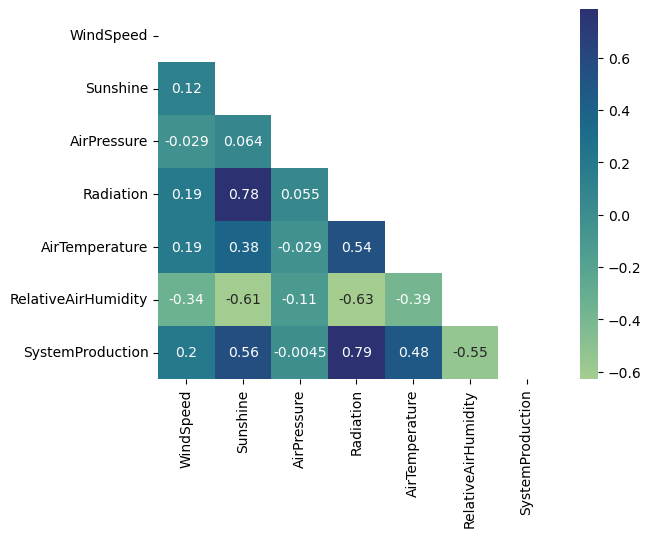

In [23]:
# Correlation Matrix:
def heatmap_cor(df):
    cor = df.corr()
    mascara = np.zeros_like(cor)
    mascara[np.triu_indices_from(mascara)] = True
    sns.heatmap(cor, mask=mascara, cbar=True, annot=True, cmap="crest")
heatmap_cor(df)

**Conclusions**

* Most of the data in SystemProduction is 0 as we expected since median is zero and the variable can't be negative.
* Outliers exist in SystemProduction, AirPressure, RelativeHumidity, Radiation, WindSpeed and Sunshine.
* All statistical tests have shown that the AirPressure not follows a normal distribution. However, all these tests are very sensitive when the sample size is large. So we can't rely on them.
* Histogram, QQ Plot, Kurtosis and Skewness tell us that AirPressue follows a normal distribution. Therefore, we will assume that AirPressure is normally distributed.
* Radiation has the highest positive correlation coefficient associated with the SystemProdution (0.79). It is also hightly correlated with Sushine column.
* RelativeAirHumidity has the lowest correlation coefficient associated with the Target. (-0.55)

# 4. **Preprocessing**

**Separating into training and testing sets**

In [24]:
# Separating variables (features and target)
X = df.drop(columns="SystemProduction")
y = df["SystemProduction"]

In [25]:
# Divinding dataset in train and test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Feature Selection**

In [26]:
# Class that put together many feature selection techniques:
class feature_selector:
    seed = 42
    def __init__(self, X, y) -> None:
        self.X_train = X
        self.y_train = y
    def randomforestR_imp(self):
        model = RandomForestRegressor(random_state=feature_selector.seed)
        model.fit(self.X_train, self.y_train)
        series = pd.Series(index=self.X_train.columns, data=model.feature_importances_)
        # Plotting RandomForest Regression Importance:
        plt.title("RandomForest Importance")
        plt.xlabel("Importance")
        sns.barplot(x=series.values, y=series.index)
        
    def xgbR_imp(self):
        model = XGBRegressor(random_state=feature_selector.seed)
        model.fit(self.X_train, self.y_train)
        series = pd.Series(index=self.X_train.columns, data=model.feature_importances_)
        # Plotting XGboost Regression Feature Importance:
        plt.title("XGBoost Feature Importance")
        plt.xlabel("Importance")
        sns.barplot(y=series.index, x=series.values)
                           
    # Univariate feature selection:
    def univariate(self, statistic, n="all"):
        selector = SelectKBest(score_func=statistic, k=n)
        selector.fit(self.X_train, self.y_train)
        series = pd.Series(index=self.X_train.columns, data=selector.scores_).sort_values(ascending=False)
        plt.title("F-Regression Filtering")
        plt.xlabel("F-score")
        sns.barplot(y=series.index, x=series.values)
        return selector
                           
    # Wrapper method for feature selection:
    def refcv(self):
        models = {
            "Lasso": Lasso(random_state=feature_selector.seed),
            "Ridge": Ridge(random_state=feature_selector.seed),
            "RandomForestR": RandomForestRegressor(random_state=feature_selector.seed),
            "ExtraTreeR": ExtraTreesRegressor(random_state=feature_selector.seed),
            "XGB": XGBRegressor(random_state=feature_selector.seed)
        }
                           
        splits = 10
        cross = KFold(n_splits=splits, random_state=feature_selector.seed, shuffle=True)
        ind = [f"Columns {i}" for i in range(1, len(self.X_train.columns) + 1)]
        df = pd.DataFrame(index=ind)
                           
        minimo = np.inf
        name = ""
        for key, model in models.items():
            rfecv = RFECV(estimator=model, step=1, cv=cross, min_features_to_select=1, scoring='neg_mean_squared_error')
            rfecv.fit(self.X_train, self.y_train)
            root_mean = np.sqrt(-rfecv.cv_results_["mean_test_score"])
            df[key] = root_mean
            best_value = root_mean[np.argmin(root_mean)]
                          
            if minimo > best_value:
                minimo = best_value
                best_features = rfecv.support_
                name = key
                          
        df_features = pd.DataFrame(columns=self.X_train.columns, data=best_features.reshape(1, -1))
        return df, df_features

In [27]:
# Feature selector object:
feature = feature_selector(X_train, y_train)

**Filtering selection**

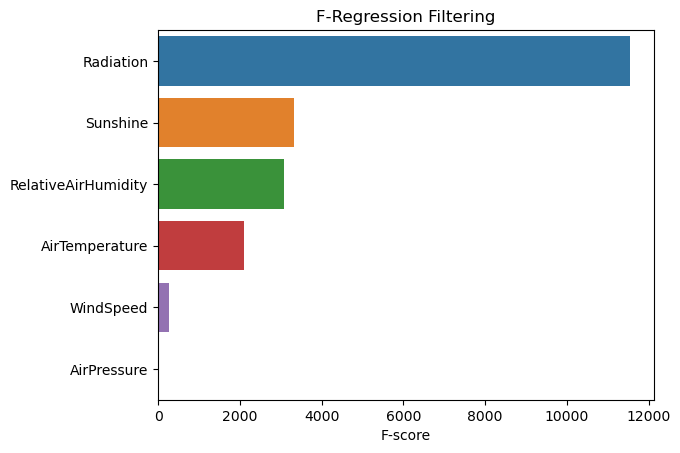

In [28]:
# Filtering feature selection using f_regression test:
selector_filtering = feature.univariate(statistic=f_regression)

**Random Forest Importance**

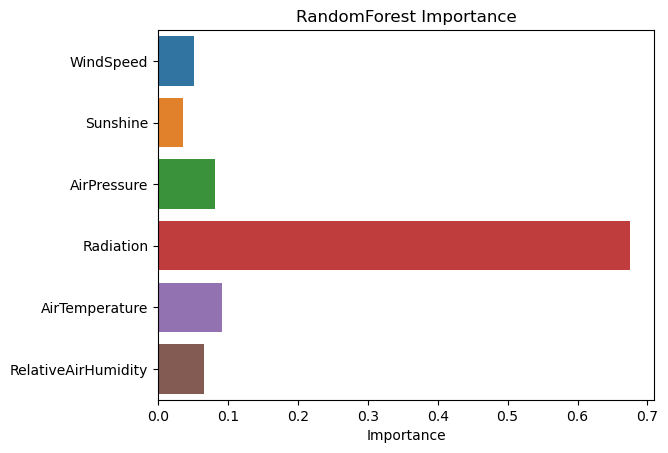

In [29]:
# Plotting Best features accordingly to the Random Forest Algorithm:
feature.randomforestR_imp()

**XGBoost Importance**

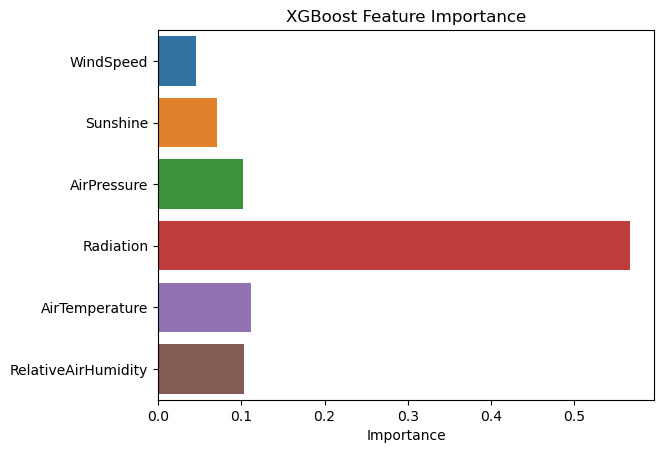

In [30]:
# Plotting the best features accordingly the XGBoost Algorithm:
feature.xgbR_imp()

**Recursive Feature Elimination (RFE)**

In [31]:
# Mean test score for all of the Algorithms and for each number of columns:
df_results, df_features = feature.refcv()

In [32]:
# Recursive Feature Elimination results:
df_results

,Lasso,Ridge,RandomForestR,ExtraTreeR,XGB
Columns 1,1467.860960,1477.986141,1133.246002,1207.972781,1045.061217
Columns 2,1301.266660,1312.583376,974.506010,1003.782575,973.252195
Columns 3,1155.614811,1158.127170,849.627134,934.740169,944.589000
Columns 4,1124.590002,1124.589720,819.966015,864.464221,848.063361
Columns 5,905.993187,905.993069,795.131463,785.949747,823.702505
Columns 6,903.620263,903.620225,772.033482,770.559293,788.551322


In [33]:
# Features selected using the best Algorithm (ExtraTreeRegression):

df_features

,WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity
0,True,True,True,True,True,True


**Transformations**

**MinMax Scaler**

**Definition:
MinMax Scaler is also called as Normalization, which is a technique that rescale all the values, usually,
within a range of 0 and 1.**


In [34]:
# MinMax Scaler Transformation:
min_max = MinMaxScaler()
X_train_min_max = min_max.fit_transform(X_train)
X_test_min_max = min_max.transform(X_test)

**Standard Scaler**

**Definition:**
* The Standard Scaler is a technique that rescales the distribution of a variable so that the mean of the observed sample is 0 and the standard deviation is 1. It is particularly useful for algorithms that rely on distance measures, such as K-means and K-nearest neighbors (KNN). Additionally, it is a recommended choice for algorithms based on neural networks.

**OBS: Standard Scaler can perform slightly worst than the other transformations because it assumes that the
data is normally distributed. However you can still standarduze your data.**

In [35]:
# Standard Scaler Transformation:
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

**Robust Scaler**

In [36]:
# Robust Scaler Transformation:
rob = RobustScaler()
X_train_rb = rob.fit_transform(X_train)
X_test_rb = rob.fit_transform(X_test)

**Selecting the best Algorithm and Transformation**

In [37]:
# Function used to evaluate the best algorithms:
def melhor_modelo(X_train, y_train):
    
    seed = 42
    cv = 5
    score = ['neg_root_mean_squared_error', 'r2']
    result_rmse = {}
    result_r2 = {}
    
    dicionario = {
                "Lasso":Lasso(random_state=seed),
                "Ridge":Ridge(random_state=seed),
                "SVR":SVR(),
                "RandomForestR":RandomForestRegressor(random_state=seed),
                "ExtraTreeR":ExtraTreesRegressor(random_state=seed),
                "XGB":XGBRegressor(random_state=seed),
                "MLP":MLPRegressor(random_state=seed, max_iter=2000)
                }
    
    for name, model in dicionario.items():
        
        k_fold = KFold(n_splits=cv, random_state=seed, shuffle=True)
        result = cross_validate(model, X_train, y_train, cv=k_fold, scoring=score)
        result_rmse[name] = -result['test_neg_root_mean_squared_error']
        result_r2[name] = result['test_r2']
        result_pd_rmse = pd.DataFrame(data=result_rmse)
        result_pd_r2 = pd.DataFrame(data=result_r2)
        
    return result_pd_rmse, result_pd_r2

**Algorithms using MinMax Scaler**

In [38]:
# Best model:
resultado_rms, resultado_r2 = melhor_modelo(X_train_min_max, y_train)

In [39]:
# Root mean squared error results:
resultado_rms.describe()

,Lasso,Ridge,SVR,RandomForestR,ExtraTreeR,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,903.485007,903.400786,1491.625424,777.359187,775.023285,796.631552,903.149462
std,15.562091,15.628135,76.724616,44.754904,37.517289,56.469978,15.249867
min,883.515021,883.085192,1368.718235,709.711976,709.776868,710.759720,884.950591
25%,897.526534,897.819708,1474.371484,767.563919,776.598713,767.368293,895.889170
50%,898.300154,898.192638,1515.347110,781.613578,793.488589,827.759964,897.119584
75%,915.613173,915.621307,1529.832640,796.014928,795.642869,834.921067,916.230928
max,922.470155,922.285084,1569.857651,831.891534,799.609385,842.348716,921.557038


In [40]:
# R2 results:
resultado_r2.describe()

,Lasso,Ridge,SVR,RandomForestR,ExtraTreeR,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.638294,0.638374,0.017998,0.732798,0.734620,0.719589,0.638508
std,0.026434,0.026218,0.015911,0.021213,0.012827,0.025073,0.027293
min,0.599661,0.600050,0.001504,0.704749,0.713481,0.687616,0.598359
25%,0.636953,0.637099,0.003063,0.716051,0.731379,0.707674,0.637671
50%,0.638390,0.638476,0.020332,0.741676,0.741629,0.712968,0.639340
75%,0.642333,0.642327,0.025882,0.748647,0.742695,0.740913,0.641850
max,0.674132,0.673919,0.039210,0.752867,0.743915,0.748775,0.675320


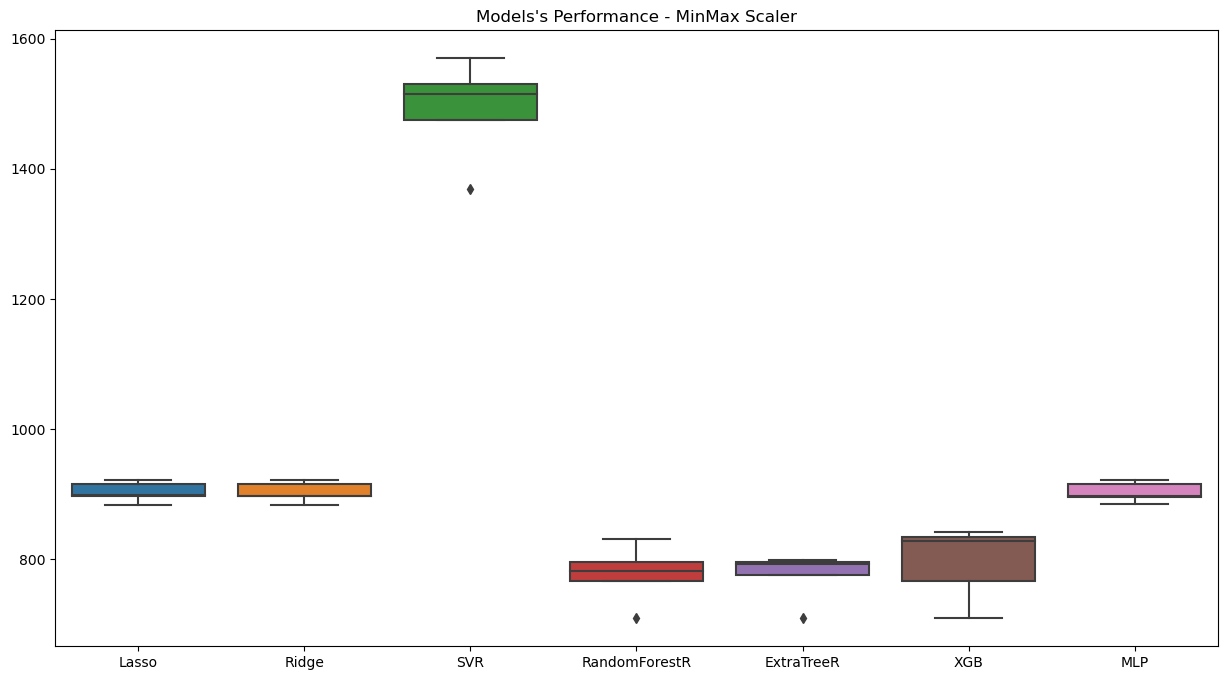

In [41]:
# PLotting model's performance:
plt.figure(figsize=(15, 8))
plt.title("Models's Performance - MinMax Scaler")
sns.boxplot(resultado_rms);

**Algorithms using Standard Scaler**

In [42]:
# Best model:
resultado_rms, resultado_r2 = melhor_modelo(X_train_std, y_train)

In [43]:
# Root mean squared error results:
resultado_rms.describe()

,Lasso,Ridge,SVR,RandomForestR,ExtraTreeR,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,903.358839,903.348724,1530.475777,777.358424,775.054472,796.703441,862.939395
std,15.613713,15.632424,77.459091,44.998844,37.425748,57.132829,22.959748
min,883.396953,883.376841,1407.559380,709.420058,709.974316,709.015132,830.902836
25%,897.503104,897.532799,1509.000499,766.761334,776.598713,768.916041,856.534749
50%,897.863026,897.762911,1557.105336,782.169400,793.488589,826.964465,863.601966
75%,915.705262,915.761676,1569.520962,796.460193,795.601359,834.373150,869.038325
max,922.325850,922.309391,1609.192706,831.981138,799.609385,844.248418,894.619098


In [44]:
# R2 results:
resultado_r2.describe()

,Lasso,Ridge,SVR,RandomForestR,ExtraTreeR,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.638397,0.638406,-0.033882,0.732799,0.734596,0.719575,0.670359
std,0.026397,0.026382,0.015623,0.021337,0.012812,0.024960,0.019834
min,0.599768,0.599786,-0.050976,0.704685,0.713481,0.688026,0.645921
25%,0.637066,0.637079,-0.047522,0.715733,0.731379,0.708236,0.658544
50%,0.638742,0.638822,-0.034406,0.741889,0.741485,0.711672,0.671233
75%,0.642261,0.642217,-0.020414,0.749172,0.742695,0.742183,0.677795
max,0.674149,0.674128,-0.016094,0.752515,0.743942,0.747761,0.698301


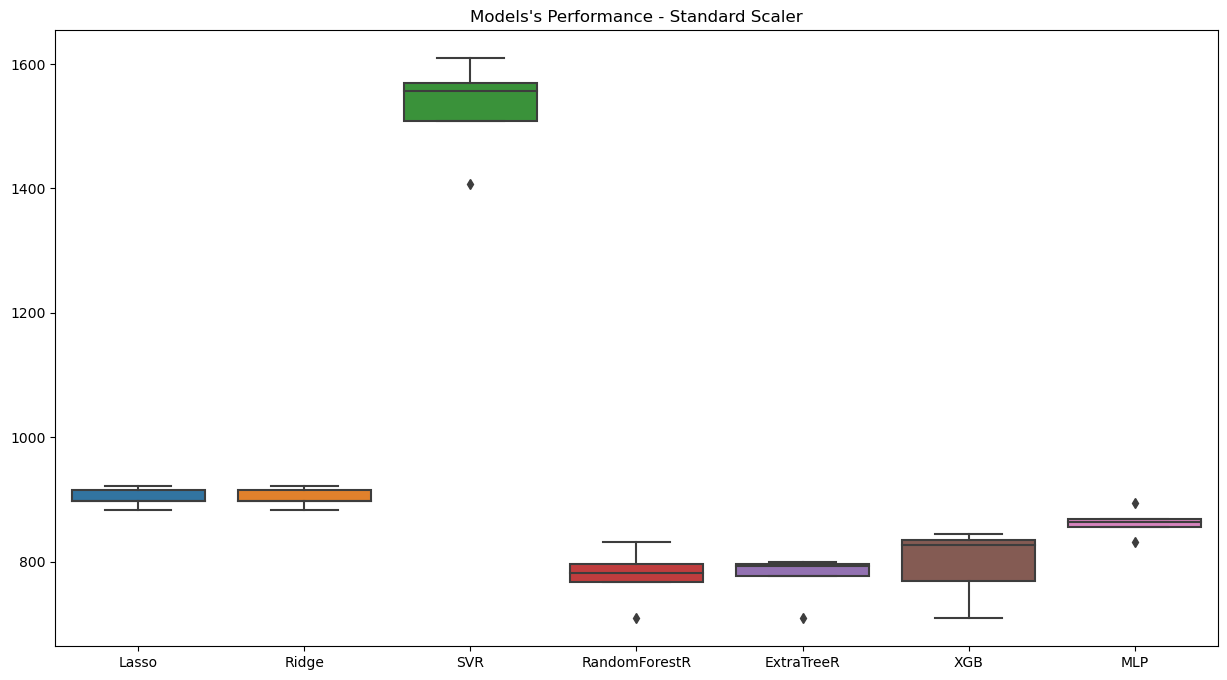

In [45]:
# PLotting model's performance:
plt.figure(figsize=(15, 8))
plt.title("Models's Performance - Standard Scaler")
sns.boxplot(resultado_rms);

**Algorithms using Robust Scaler**

In [46]:
# Best model:
resultado_rms, resultado_r2 = melhor_modelo(X_train_rb, y_train)

In [47]:
# Root mean squared error results:
resultado_rms.describe()

,Lasso,Ridge,SVR,RandomForestR,ExtraTreeR,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,903.355648,903.348361,1482.596356,777.415145,775.018174,796.668225,876.956954
std,15.623197,15.632835,78.002979,44.754342,37.423964,57.775051,14.926458
min,883.412700,883.384740,1357.623438,709.669560,709.974316,706.881966,863.292220
25%,897.497262,897.526871,1464.431309,767.355707,776.417221,770.807039,867.246465
50%,897.797461,897.752247,1507.997183,781.161161,793.488589,826.768020,870.690222
75%,915.742087,915.767967,1521.297606,797.640675,795.601359,834.138524,883.666721
max,922.328731,922.309982,1561.632242,831.248623,799.609385,844.745576,899.889140


In [48]:
# R2 results:
resultado_r2.describe()

,Lasso,Ridge,SVR,RandomForestR,ExtraTreeR,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.638400,0.638406,0.029921,0.732748,0.734621,0.719632,0.658997
std,0.026403,0.026386,0.017796,0.021397,0.012831,0.024936,0.028769
min,0.599753,0.599779,0.012615,0.705205,0.713481,0.688201,0.614268
25%,0.637064,0.637079,0.013483,0.714890,0.731379,0.708374,0.654509
50%,0.638794,0.638831,0.029812,0.741707,0.741485,0.711332,0.666025
75%,0.642232,0.642212,0.038972,0.748783,0.742815,0.743732,0.666856
max,0.674153,0.674132,0.054723,0.753153,0.743942,0.746519,0.693328


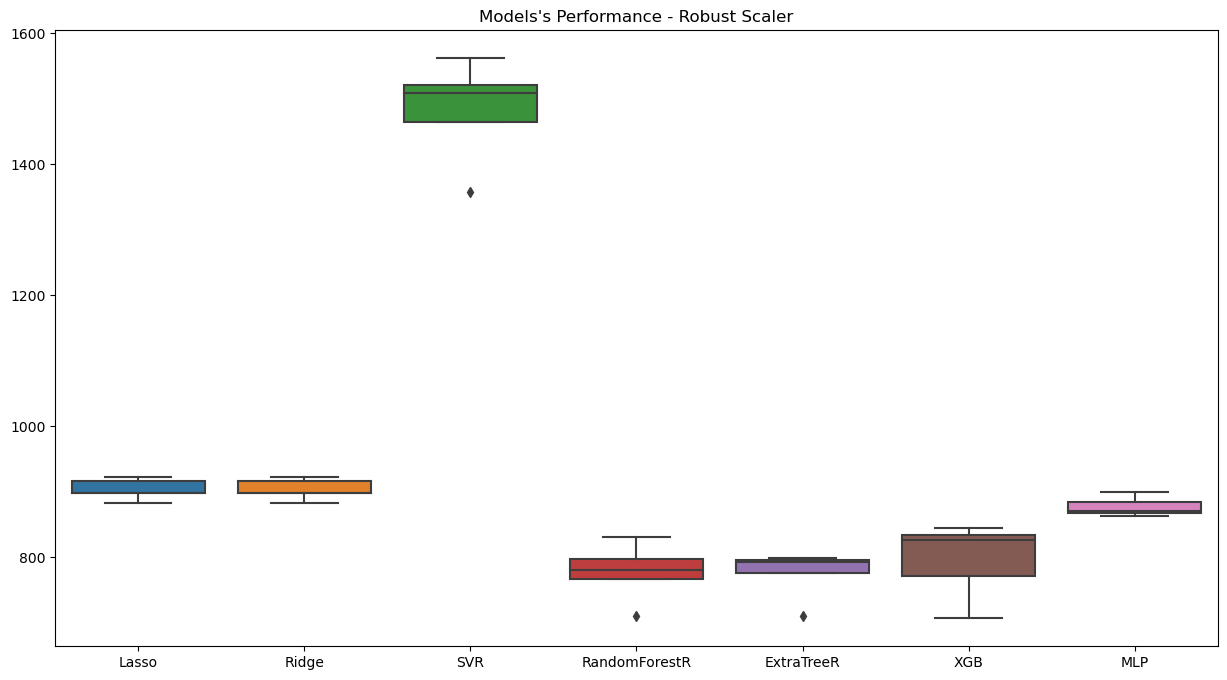

In [49]:
# PLotting model's performance:
plt.figure(figsize=(15, 8))
plt.title("Models's Performance - Robust Scaler")
sns.boxplot(resultado_rms);

**Conclusions**
* ExtraTres was the best Algorithm for all of the transformation algorithms.
* The Best Trasformation algorithm was Robust Scaler.

**RMSE:**
* Average: 775.018174
* Standard Deviation: 37.423964

**R2**
* Average: 0.734621
* Standard Deviation: 0.012831

**Fine Tuning**

In [50]:
# Function for fine tuning an arbitrary model:
def tuning(X_train, y_train, modelo, params):
    cv = 5
    score = "neg_root_mean_squared_error"
    grid = GridSearchCV(modelo, cv=cv, param_grid=params,
                        scoring=score,n_jobs=-1,
                        return_train_score=True,
                       )
    
    grid.fit(X_train, y_train)
    
    best_index = grid.best_index_
    result = grid.cv_results_
    
    train_score = -result['mean_train_score'][best_index]
    left_out = -result['mean_test_score'][best_index]
    
    print(f"Train score: {train_score}")
    print(f"Left out data score: {left_out}")
    
    return grid.best_estimator_

In [51]:
def save_model(model):
    try:
        joblib.dump(model, "modelo/extra_tree_model.joblib")
    except:
        os.makedirs("modelo")
        path = "modelo/extra_tree_model.joblib"
        joblib.dump(model, path)

In [52]:
# Hypeparameters grid:
params = {"n_estimators":[100, 110, 120],
    "max_depth":[4, 5, 6, 7],
    "max_features":[0.5, 0.6, 0.7],
    "min_samples_split":[3, 5, 6, 7, 10]}

In [53]:
# Fine Tuning an ExtraTreeRegressor:
extra_tree = ExtraTreesRegressor(random_state=42)
best_estimator = tuning(X_train_rb, y_train, extra_tree, params)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Train score: 765.3644951871554
Left out data score: 835.5946923397969


In [54]:
# Saving the best model:
save_model(best_estimator)

# 5.**Predictions**

In [55]:
# Training the best model using the whole training set:
best_model = clone(best_estimator)
best_model.fit(X_train_rb, y_train)

ExtraTreesRegressor(max_depth=7, max_features=0.7, min_samples_split=3,
                    n_estimators=110, random_state=42)

In [56]:
# Computing Metrics for the training set:
y_pred = best_model.predict(X_train_rb)
rms_train = np.sqrt(mean_squared_error(y_pred, y_train))
r2_train = r2_score(y_pred, y_train)
print("Train set:")
print(f"RMSE: {rms_train}")
print(f"R2: {r2_train}")

Train set:
RMSE: 777.204892038056
R2: 0.5682232687504819


In [57]:
# Computing Metrics for the test set:
y_pred = best_model.predict(X_test_rb)
rmse_test = np.sqrt(mean_squared_error(y_pred, y_test))
r2_test = r2_score(y_pred, y_test)
print("Test set:")
print(f"RMSE: {rmse_test}")
print(f"R2: {r2_test}")

Test set:
RMSE: 819.7307706495565
R2: 0.5347937839096278


# **Conclusions**

* RMSE improved from 835.595 to 819.731.
* R2 score is approximately 0.5349.
* Model does not seem to suffer from Overfitting.